In [1]:
%pip install pennylane  --upgrade pip
%pip install pennylane-lightning  --upgrade pip

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pennylane as qml
#import pennylane_lightning as qml
import matplotlib.pyplot as plt
import numpy as np
import math

In [3]:
import gzip

def load_chromosome(filepath):
    genome = ""
    with gzip.open(filepath, "rt") as f:
        for line in f:
            if not line.startswith(">"):
                genome += line.strip()
    return genome

genome = load_chromosome("chr22.fa.gz")



In [4]:
print("Length:", len(genome))
print("Unique bases overall:", set(genome))
print("First 200 chars:", genome[:200])
print("Somewhere in middle:", genome[200000:200200])


Length: 50818468
Unique bases overall: {'A', 'g', 't', 'C', 'G', 'c', 'N', 'T', 'a'}
First 200 chars: NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
Somewhere in middle: NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


In [5]:
sgRNA = "ACGTACGTACGTACGTACGT"


In [ ]:
#candidates = [genome[i:i+L] for i in range(len(genome)-L+1)]
#N = len(candidates)


Chunk generator

In [ ]:
#candidates = extract_candidates(chunk, L)


old oracle

new oracle

In [15]:
def build_grover_circuit(num_qubits):

    dev = qml.device("lightning.qubit", wires=num_qubits)

    def equal_superposition(wires):
        for w in wires:
            qml.Hadamard(wires=w)

    def oracle(valid_indices, wires):
        for idx in valid_indices:
            bitstring = format(idx, f'0{num_qubits}b')
            bits = np.array([int(b) for b in bitstring])
            qml.FlipSign(bits, wires=wires)

    def diffusion(wires):

    # Special case: only 1 qubit
        if len(wires) == 1:
            qml.Hadamard(wires=wires[0])
            qml.PauliX(wires=wires[0])
            qml.PauliZ(wires=wires[0])
            qml.PauliX(wires=wires[0])
            qml.Hadamard(wires=wires[0])
        return

    # Normal multi-qubit case
        for w in wires:
            qml.Hadamard(wires=w)
            qml.PauliX(wires=w)

            qml.Hadamard(wires=wires[-1])
            qml.MultiControlledX(wires=wires[:-1] + [wires[-1]])
            qml.Hadamard(wires=wires[-1])

        for w in wires:
            qml.PauliX(wires=w)
            qml.Hadamard(wires=w)

    def grover_iterations(N, M):
        return int(np.ceil(np.pi/4 * np.sqrt(N/M)))

    @qml.qnode(dev)
    def circuit(valid_indices):

        wires = list(range(num_qubits))
        N = 2**num_qubits
        M = max(1, len(valid_indices))

        equal_superposition(wires)

        for _ in range(grover_iterations(N, M)):
            oracle(valid_indices, wires)
            diffusion(wires)

        return qml.probs(wires=wires)

    return circuit


In [ ]:
def build_grover_circuit(num_qubits):

    dev = qml.device("default.qubit", wires=num_qubits)

    def equal_superposition(wires):
        for w in wires:
            qml.Hadamard(wires=w)

    def oracle(valid_indices, wires):
        for idx in valid_indices:
            bitstring = format(idx, f'0{num_qubits}b')
            bits = np.array([int(b) for b in bitstring])
            qml.FlipSign(bits, wires=wires)

    def grover_iterations(N, M):
        return int(np.ceil(np.pi/4 * np.sqrt(N/M)))

    @qml.qnode(dev)
    def circuit(valid_indices):

        wires = list(range(num_qubits))
        N = 2**num_qubits
        M = max(1, len(valid_indices))

        equal_superposition(wires)

        for _ in range(grover_iterations(N, M)):
            oracle(valid_indices, wires)
            qml.templates.GroverOperator(wires=wires)

        return qml.probs(wires=wires)

    return circuit


In [56]:
genome = genome.upper()

In [28]:
chunk_size = 16384
L = len(sgRNA)
threshold = 6

overlap = L - 1
step = chunk_size - overlap

all_matches = []

for start in range(0, len(genome), step):

    chunk = genome[start:start+chunk_size]

    candidates = [
        chunk[i:i+L]
        for i in range(len(chunk)-L+1)
        if 'N' not in chunk[i:i+ L]
    ]

    valid_indices = [
        i for i, seq in enumerate(candidates)
        if sum(a != b for a,b in zip(seq, sgRNA)) <= threshold
    ]

    if len(valid_indices) == 0:
        continue

    N = len(candidates)

    if N< 2:
        continue


    num_qubits = max(1,math.ceil(math.log2(N)))

   

    grover_circuit = build_grover_circuit(num_qubits)

    if len(valid_indices) > 0:



       probs = grover_circuit(valid_indices)

    

    # Extract amplified states
    top_states = np.argsort(probs)[-len(valid_indices):]

    for idx in top_states:
        global_position = start + idx
        all_matches.append(global_position)


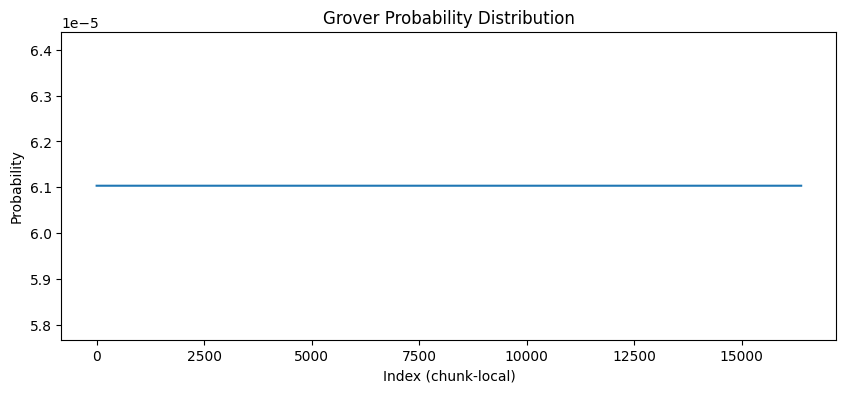

In [29]:
plt.figure(figsize=(10,4))
plt.plot(probs)
plt.xlabel("Index (chunk-local)")
plt.ylabel("Probability")
plt.title("Grover Probability Distribution")
plt.show()

In [30]:
print(set(genome[:100000]))


{'N'}


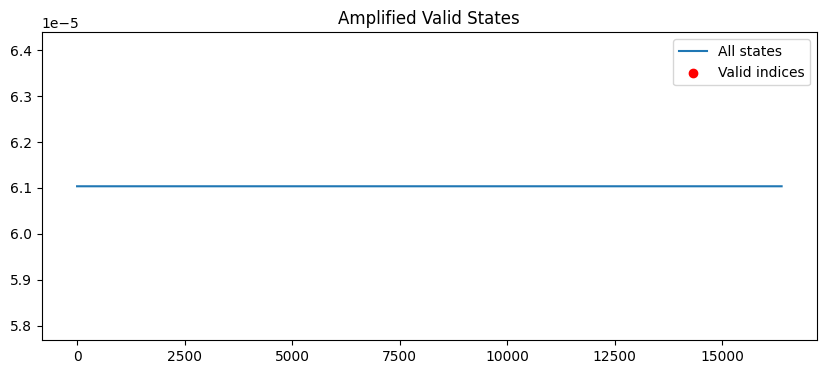

In [31]:
plt.figure(figsize=(10,4))
plt.plot(probs, label="All states")

plt.scatter(
    valid_indices,
    probs[valid_indices],
    color='red',
    label="Valid indices"
)

plt.legend()
plt.title("Amplified Valid States")
plt.show()


In [46]:
def print_top_states(probs, k=10):
    top = np.argsort(probs)[-k:][::-1]
    for i in top:
        print(f"State {i:012b} | Index {i} | Prob {probs[i]:.6f}")


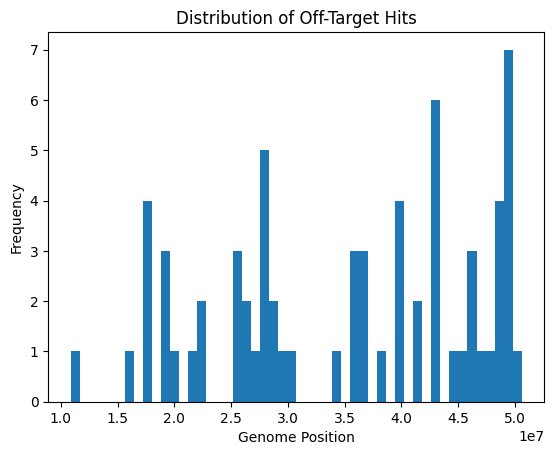

In [34]:
plt.hist(all_matches, bins=50)
plt.xlabel("Genome Position")
plt.ylabel("Frequency")
plt.title("Distribution of Off-Target Hits")
plt.show()


In [27]:
print(len(valid_indices))


0


In [22]:
total_matches = 0
total_candidates = 0

for start in range(0, len(genome), 100000):  # large step just for estimation
    chunk = genome[start:start+100000]
    candidates = [chunk[i:i+L] for i in range(len(chunk)-L+1)]
    matches = sum(
        sum(a != b for a,b in zip(seq, sgRNA)) <= threshold
        for seq in candidates
    )
    total_matches += matches
    total_candidates += len(candidates)

print("Estimated match rate:", total_matches / total_candidates)


Estimated match rate: 1.318669284769722e-06
